In [62]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from keras.datasets import mnist

In [63]:
class MnistClassifierInterface(ABC):
    @abstractmethod
    def train(self, train_loader, val_loader, epochs):
        pass

    @abstractmethod
    def predict(self, test_loader):
        pass

In [64]:
def load_mnist_data(batch_size, reshape_cnn=False):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.astype(np.float32) / 255.0
    x_test = x_test.astype(np.float32) / 255.0
    if reshape_cnn:
        x_train = x_train.reshape(-1, 1, 28, 28)
        x_test = x_test.reshape(-1, 1, 28, 28)
    else:
        x_train = x_train.reshape(-1, 28*28)
        x_test = x_test.reshape(-1, 28*28)

    X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
    train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train).long())
    val_dataset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val).long())
    test_dataset = TensorDataset(torch.tensor(x_test), torch.tensor(y_test).long())

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [65]:
class RandomForestMnistClassifier(MnistClassifierInterface):
    def __init__(self):
        self.model = None
        self.history = []

    def _prepare_data(self, data_loader):
        X, y = [], []
        for images, labels in data_loader:
            images = images.view(images.shape[0], -1).numpy()
            labels = labels.numpy()
            X.extend(images)
            y.extend(labels)
        return np.array(X), np.array(y)

    def train(self, train_loader, val_loader=None, test_loader=None, epochs=None):
        X_train, y_train = self._prepare_data(train_loader)
        X_val, y_val = self._prepare_data(val_loader)

        print(f"Training samples: {len(X_train)}")
        print(f"Validation samples: {len(X_val)}")

        param_grid = {
            'n_estimators': [300, 500],
            'max_depth': [8, 10, 15],
            'max_features': [10, 15, 25],
            'min_samples_leaf': [5, 10]
        }

        rf = RandomForestClassifier(random_state=42)
        grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=1, scoring='accuracy')

        print("Running GridSearchCV:")
        grid_search.fit(X_train, y_train)

        best_params = grid_search.best_params_
        print(f"Best parameters: {best_params}")

        self.model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
        self.model.fit(X_train, y_train)
        print("Random Forest training done!")

        train_acc = self.model.score(X_train, y_train)
        val_acc = self.model.score(X_val, y_val)

        print(f"Final Train Accuracy: {train_acc:.4f}")
        print(f"Final Validation Accuracy: {val_acc:.4f}")

    def predict(self, test_loader):
        print("Evaluating Random Forest:")
        X_test, y_test = self._prepare_data(test_loader)
        y_pred = self.model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Test Accuracy: {accuracy:.4f}")
        print("Classification Report:")
        print(classification_report(y_test, y_pred))

        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

In [ ]:
BATCH_SIZE = 64
NUM_FILTERS1 = 32
NUM_FILTERS2 = 64
FC1_UNITS = 128
LEARNING_RATE = 0.0001
EPOCHS = 30
PATIENCE = 3

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class CNNMnistClassifier:
    def __init__(self):
        self.model = CNN()
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

class CNNMnistClassifier:
    def __init__(self):
        self.model = CNN()
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.train_losses = []
        self.val_losses = []

    def train(self, train_loader, val_loader, epochs=EPOCHS, patience=PATIENCE):
        best_val_loss = float('inf')
        counter = 0

        for epoch in range(epochs):
            self.model.train()
            train_loss = 0

            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                train_loss += loss.item()
            
            train_loss /= len(train_loader)
            self.train_losses.append(train_loss)
            self.model.eval()
            val_loss = 0
            correct = 0
            total = 0

            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            
            val_loss /= len(val_loader)
            val_accuracy = correct / total
            self.val_losses.append(val_loss)

            print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2%}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0
                torch.save(self.model.state_dict(), "best_model.pth")
            else:
                counter += 1
                if counter >= patience:
                    print("Early stopping.")
                    break

        plt.figure(figsize=(8, 6))
        plt.plot(self.train_losses, label="Train Loss", marker="o")
        plt.plot(self.val_losses, label="Validation Loss", marker="o")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.grid()
        plt.show()


    def predict(self, test_loader):
        self.model.load_state_dict(torch.load("best_model.pth"))
        self.model.eval()
        correct = 0
        total = 0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        accuracy = 100 * correct / total
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)  # Виправлення!

        print(f'\nTest Accuracy: {accuracy:.2f}%')
        print(f'Recall: {recall:.2f}')

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()


In [67]:
BATCH_SIZE_FF = 64
HIDDEN_SIZE_FF = 256
LEARNING_RATE_FF = 0.0001
EPOCHS_FF = 50
PATIENCE_FF = 3

class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes=10, dropout_rate=0.2):
        super(FFNN, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.l2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.l2(out)
        return out

class FFNNMnistClassifier:
    def __init__(self, input_size=28*28, hidden_size=HIDDEN_SIZE_FF, lr=LEARNING_RATE_FF):
        self.model = FFNN(input_size, hidden_size, num_classes=10)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)
        self.train_losses = []
        self.val_losses = []

    def train(self, train_loader, val_loader, epochs=EPOCHS_FF, patience=PATIENCE_FF):
        best_val_loss = float('inf')
        counter = 0
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0
            for images, labels in train_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            train_loss /= len(train_loader)
            self.train_losses.append(train_loss)

            self.model.eval()
            val_loss = 0
            correct, total = 0, 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_loss /= len(val_loader)
            val_accuracy = correct / total
            self.val_losses.append(val_loss)

            print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2%}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0
                torch.save(self.model.state_dict(), "best_ffnn.pth")
            else:
                counter += 1
                if counter >= patience:
                    print("Early stopping.")
                    break

        plt.figure(figsize=(8, 6))
        plt.plot(self.train_losses, label="Train Loss", marker="o")
        plt.plot(self.val_losses, label="Validation Loss", marker="o")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training and Validation Loss")
        plt.legend()
        plt.grid()
        plt.show()

    def predict(self, test_loader):
        self.model.load_state_dict(torch.load("best_ffnn.pth"))
        self.model.eval()
        correct, total = 0, 0
        y_true, y_pred = [], []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = F.softmax(self.model(images), dim=1)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        accuracy = 100.0 * correct / total
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)

        print(f"\nTest Accuracy: {accuracy:.2f}%")
        print(f"Recall: {recall:.2f}")

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix for FFNN')
        plt.show()


In [68]:
class MnistClassifier:
    def __init__(self, algorithm):
        if algorithm == 'cnn':
            self.classifier = CNNMnistClassifier()
        elif algorithm == 'rf':
            self.classifier = RandomForestMnistClassifier()
        elif algorithm == 'nn':
            self.classifier = FFNNMnistClassifier()
        else:
            raise ValueError("Choose from 'cnn', 'rf', or 'nn'.")

    def train(self, train_loader, val_loader, epochs=None):
        if epochs is not None:
            self.classifier.train(train_loader, val_loader, epochs)
        else:
            self.classifier.train(train_loader, val_loader)

    def predict(self, test_loader):
        if self.classifier:
            self.classifier.predict(test_loader)

In [69]:
train_loader, val_loader, test_loader = load_mnist_data(batch_size=64, reshape_cnn=False)
train_loader_cnn, val_loader_cnn, test_loader_cnn = load_mnist_data(batch_size=64, reshape_cnn=True)

Training samples: 48000
Validation samples: 12000
Running GridSearchCV:
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'max_depth': 15, 'max_features': 25, 'min_samples_leaf': 5, 'n_estimators': 500}
Random Forest training done!
Final Train Accuracy: 0.9883
Final Validation Accuracy: 0.9617
Evaluating Random Forest:
Test Accuracy: 0.9626
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.95      0.96      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.96      0.96       982
           5       0.97      0.95      0.96       892
           6       0.97      0.97      0.97       958
           7       0.97      0.95      0.96      1028
           8       0.96      0.95      0.95       974
           9       0.94      0.95      0.94      1009

    accu

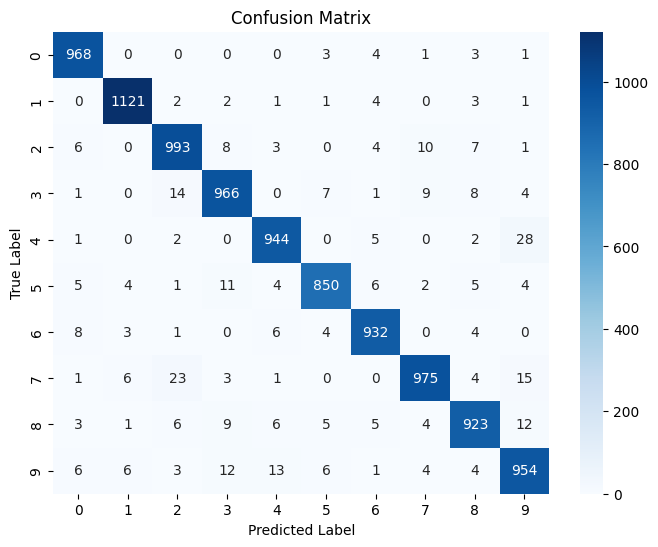

In [18]:
algorithm = 'rf'
mnist_classifier = MnistClassifier(algorithm=algorithm)
mnist_classifier.train(train_loader, val_loader)
mnist_classifier.predict(test_loader)

Epoch 1: Train Loss: 0.6105, Val Loss: 0.2517, Val Accuracy: 92.70%
Epoch 2: Train Loss: 0.1949, Val Loss: 0.1452, Val Accuracy: 95.78%
Epoch 3: Train Loss: 0.1277, Val Loss: 0.1122, Val Accuracy: 96.80%
Epoch 4: Train Loss: 0.0960, Val Loss: 0.0974, Val Accuracy: 97.26%
Epoch 5: Train Loss: 0.0787, Val Loss: 0.0812, Val Accuracy: 97.71%
Epoch 6: Train Loss: 0.0673, Val Loss: 0.0708, Val Accuracy: 97.91%
Epoch 7: Train Loss: 0.0593, Val Loss: 0.0728, Val Accuracy: 97.77%
Epoch 8: Train Loss: 0.0528, Val Loss: 0.0578, Val Accuracy: 98.24%
Epoch 9: Train Loss: 0.0478, Val Loss: 0.0515, Val Accuracy: 98.45%
Epoch 10: Train Loss: 0.0434, Val Loss: 0.0510, Val Accuracy: 98.58%
Epoch 11: Train Loss: 0.0404, Val Loss: 0.0518, Val Accuracy: 98.42%
Epoch 12: Train Loss: 0.0354, Val Loss: 0.0446, Val Accuracy: 98.59%
Epoch 13: Train Loss: 0.0339, Val Loss: 0.0431, Val Accuracy: 98.73%
Epoch 14: Train Loss: 0.0305, Val Loss: 0.0416, Val Accuracy: 98.71%
Epoch 15: Train Loss: 0.0288, Val Loss: 0.0

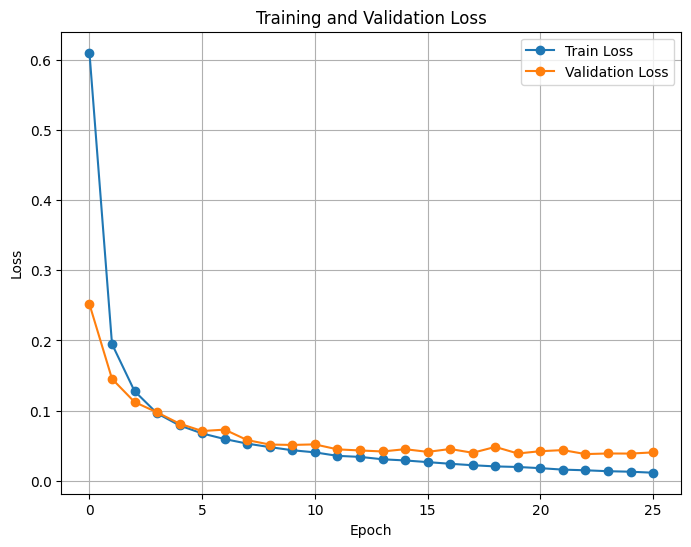

<ipython-input-33-0c4b85857d99>:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load("best_model.pth"))



Test Accuracy: 98.91%
Recall: 0.99


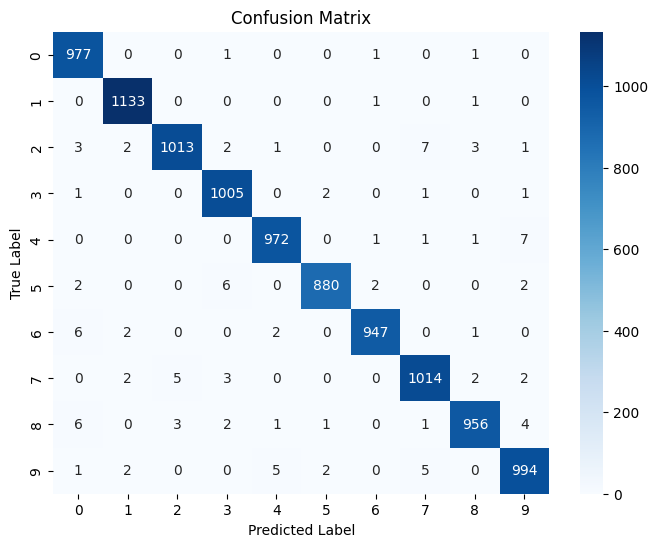

In [34]:
algorithm = 'cnn'
mnist_classifier = MnistClassifier(algorithm=algorithm)
mnist_classifier.train(train_loader_cnn, val_loader_cnn, EPOCHS)
mnist_classifier.predict(test_loader_cnn)

Epoch 1: Train Loss: 0.8891, Val Loss: 0.4232, Val Accuracy: 89.32%
Epoch 2: Train Loss: 0.3813, Val Loss: 0.3211, Val Accuracy: 91.25%
Epoch 3: Train Loss: 0.3132, Val Loss: 0.2760, Val Accuracy: 92.43%
Epoch 4: Train Loss: 0.2775, Val Loss: 0.2500, Val Accuracy: 92.94%
Epoch 5: Train Loss: 0.2499, Val Loss: 0.2277, Val Accuracy: 93.73%
Epoch 6: Train Loss: 0.2287, Val Loss: 0.2097, Val Accuracy: 94.19%
Epoch 7: Train Loss: 0.2106, Val Loss: 0.1955, Val Accuracy: 94.54%
Epoch 8: Train Loss: 0.1945, Val Loss: 0.1830, Val Accuracy: 94.82%
Epoch 9: Train Loss: 0.1800, Val Loss: 0.1717, Val Accuracy: 95.20%
Epoch 10: Train Loss: 0.1687, Val Loss: 0.1610, Val Accuracy: 95.53%
Epoch 11: Train Loss: 0.1571, Val Loss: 0.1529, Val Accuracy: 95.71%
Epoch 12: Train Loss: 0.1487, Val Loss: 0.1452, Val Accuracy: 95.93%
Epoch 13: Train Loss: 0.1381, Val Loss: 0.1377, Val Accuracy: 95.98%
Epoch 14: Train Loss: 0.1311, Val Loss: 0.1316, Val Accuracy: 96.15%
Epoch 15: Train Loss: 0.1242, Val Loss: 0.1

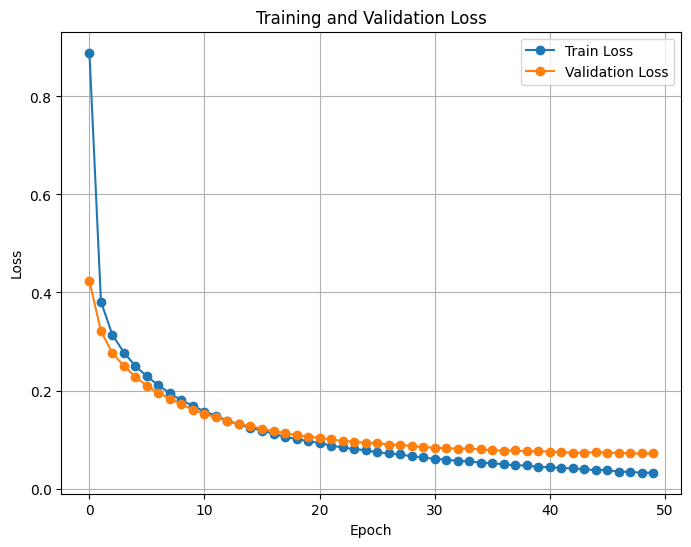

<ipython-input-67-a75511afaf48>:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load("best_ffnn.pth"))



Test Accuracy: 97.95%
Recall: 0.98


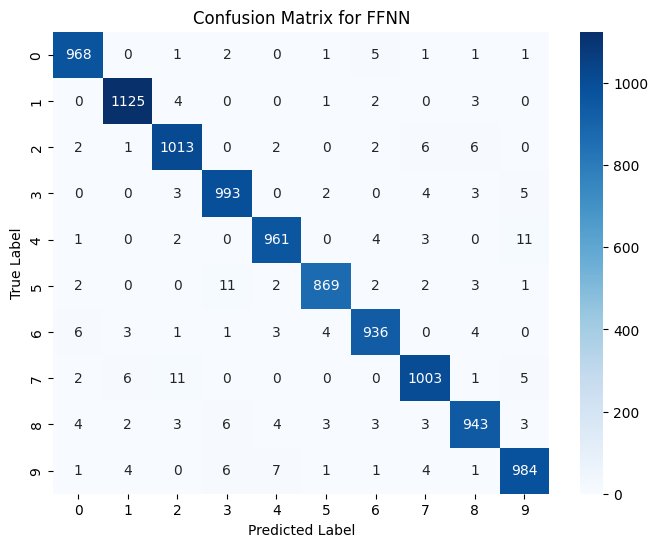

In [70]:
algorithm = 'nn'
mnist_classifier = MnistClassifier(algorithm=algorithm)
mnist_classifier.train(train_loader, val_loader, EPOCHS_FF)
mnist_classifier.predict(test_loader)